In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import subprocess
import getpass
import sqlite3
import time
import psycopg2
from scipy.interpolate import UnivariateSpline
import json
%matplotlib inline
from IPython.core.display import HTML
pd.options.display.max_columns = 500
#import seaborn as sb
import datetime
from sqlalchemy import create_engine
from difflib import SequenceMatcher, get_close_matches
from IPython.core.display import HTML

HTML("<style>.container { width:100% !important; }</style>")

# Aim of this notebook

On Tuesday the 7th of November, a 28 year old girl died in Schaarbeek by a car accident (http://www.standaard.be/cnt/dmf20171108_03176400). The driver drove around 90km/hr where could drive 30km/hr. As I live very close by, and use my bike a lot, I was of course angry and scared. But as a statistician, I wanted to know if this is a real issue or just an outlier.
<br><br>
By studying the Belgian open data, I looked for answers for the following three questions:
- Are there today more accidents in Schaarbeek than in other Belgian communes?
- What about the trend in Schaarbeek? Is it getting better or worse? 
- Is the budget of the police per commune per inhabitant correlated with the number of accidents per commune per inhabitant?

I did not have the time to start answering the last question.



### Read in data and meta data

#### Open data regarding traffic accidents

- comes from: http://statbel.fgov.be/nl/statistieken/opendata/datasets/circulation_et_transport/victimes/
- first issue with the open data, year 2003 and 2004 are missing

#### Number of inhabitatns per commune

- comes from: http://statbel.fgov.be/nl/modules/publications/statistiques/bevolking/bevolking_-_cijfers_bevolking_2010_-_2012.jsp
- as the data goes only from 2010 to 2016, I made a simple linear regression model to estimate the inhabitants per commune from 1995 until 2016

In [3]:
# Metadata traffic accidents
metadata = pd.read_excel('metadata.xlsx')
column_mapping = {}
for i, row in metadata.iterrows():
    column_mapping[row['NAME']] = row['LABEL']

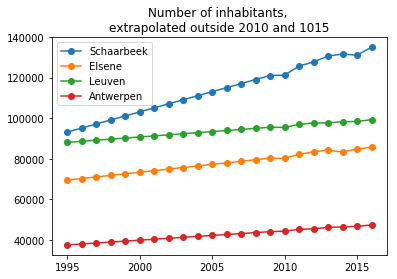

In [39]:
# Number of inhibitants
for i, year in enumerate(np.arange(start=2010, stop=2016)):
    inwoners_year = pd.read_excel('inwoners.xls', skiprows=2, sheetname='Loop van de bevolking in {}'.format(year))
    inwoners_year = inwoners_year.iloc[:,0:3]
    inwoners_year.columns=['niscode', 'gemeente', 'inwoners']
    inwoners_year['year'] = year
    if(i==0): aantal_inwoners = inwoners_year
    else: aantal_inwoners = pd.concat([aantal_inwoners, inwoners_year], axis=0)

# Hier zitten doubles in?
aantal_inwoners = aantal_inwoners.drop_duplicates()

from scipy import stats
# Fill in the missing years with a linear regression
for i, gemeente in enumerate(np.unique(aantal_inwoners['gemeente'])):
    subset = aantal_inwoners.loc[aantal_inwoners['gemeente']==gemeente, :]
    # Create linear regression object
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset['year'], subset['inwoners'])
    # Predict the other years
    to_predict = pd.DataFrame.from_dict({'year':list(np.arange(1995, 2010))+[2016], 
                        'inwoners':np.repeat(0, len(np.arange(1995, 2010))+1)})
    to_predict['gemeente'] = gemeente
    to_predict['niscode'] = subset['niscode'].values[0]
    to_predict['inwoners'] = np.round(intercept + slope * to_predict['year'])
    # Add the predictions to aantal inwoners
    aantal_inwoners = pd.concat([aantal_inwoners, to_predict], axis=0)

aantal_inwoners = aantal_inwoners.sort_values(['gemeente', 'year'])

plt.plot(aantal_inwoners.loc[aantal_inwoners['gemeente']=='Schaarbeek', 'year'],
         aantal_inwoners.loc[aantal_inwoners['gemeente']=='Schaarbeek', 'inwoners'], 'o-', label='Schaarbeek')
plt.plot(aantal_inwoners.loc[aantal_inwoners['gemeente']=='Elsene', 'year'],
         aantal_inwoners.loc[aantal_inwoners['gemeente']=='Elsene', 'inwoners'], 'o-', label='Elsene')
plt.plot(aantal_inwoners.loc[aantal_inwoners['gemeente']=='Leuven', 'year'],
         aantal_inwoners.loc[aantal_inwoners['gemeente']=='Leuven', 'inwoners'], 'o-', label='Leuven')
plt.plot(aantal_inwoners.loc[aantal_inwoners['gemeente']=='Etterbeek', 'year'],
         aantal_inwoners.loc[aantal_inwoners['gemeente']=='Etterbeek', 'inwoners'], 'o-', label='Antwerpen')
plt.title('Number of inhabitants, \nextrapolated outside 2010 and 1015')
plt.legend()

In [5]:
# Traffic accidents data, takes a while.
for i, filename in enumerate(os.listdir('accidents')):
    print('Reading file {}'.format(filename))
    data_year = pd.read_excel('accidents/{}'.format(filename))

    if(i==0): accidents = data_year
    else: accidents = pd.concat([accidents, data_year], axis=0)
    

Reading file data_1995.xlsx
Reading file data_1996.xlsx
Reading file data_1997.xlsx
Reading file data_1998.xlsx
Reading file data_1999.xlsx
Reading file data_2000.xlsx
Reading file data_2001.xlsx
Reading file data_2002.xlsx
Reading file data_2005.xlsx
Reading file data_2006.xlsx
Reading file data_2007.xlsx
Reading file data_2008.xlsx
Reading file data_2009.xlsx
Reading file data_2010.xlsx
Reading file data_2011.xlsx
Reading file data_2012.xlsx
Reading file data_2013.xlsx
Reading file data_2014.xlsx
Reading file data_2015.xlsx
Reading file data_2016.xlsx


In [6]:
# Extract brussels communes out of the data
brusselse_gemeenten = list(np.unique(accidents.loc[accidents['TX_RGN_DESCR_NL']=='Brussels Hoofdstedelijk Gewest','TX_MUNTY_DESCR_NL']))

## Clean up some data issues

- The traffic data excel file of the year 1997 is inconsistent with the other years, the columns do not match. As I can't translate the columns, I decided not to further use it.
- I select only a couple of columns which are usefull for this analysis

In [40]:
accidents_cleaned = accidents.copy()

In [41]:
# There is an issue with some years, there are columns that other years dont have
columns_not_in_meta_data = [column for column in accidents_cleaned.columns if column not in column_mapping.keys()]
print('Columns not in the meta data: {}'.format(', '.join(columns_not_in_meta_data)))
print('Years that have this problem: {}'.format(list(np.unique(accidents_cleaned.loc[~accidents_cleaned['MS_ACCT'].isnull(),'DT_DAY'].map(lambda x: x.year)))))
# Delete year 1997
accidents_cleaned['year'] = accidents_cleaned['DT_DAY'].map(lambda x: x.year)
accidents_cleaned = accidents_cleaned.loc[accidents_cleaned['year']!= 2017]
accidents_cleaned = accidents_cleaned.drop(columns_not_in_meta_data, axis=1)

Columns not in the meta data: MS_ACCT, MS_ACCT_WITH_DEAD, MS_ACCT_WITH_DEAD_30_DAYS, MS_ACCT_WITH_MORY_INJ, MS_ACCT_WITH_SERLY_INJ, MS_ACCT_WITH_SLY_INJ
Years that have this problem: [1997]


In [42]:
# Only keep relevant columns, and give them the names from the meta data
accidents_cleaned = accidents_cleaned[['DT_DAY', 'MS_VCT', 'MS_SLY_INJ', 'MS_SERLY_INJ', 'MS_MORY_INJ', 'MS_DEAD', 'MS_DEAD_30_DAYS', 'TX_VCT_TYPE_DESCR_NL',
           'TX_ROAD_USR_TYPE_DESCR_NL', 'TX_ROAD_TYPE_DESCR_NL', 'TX_LIGHT_COND_DESCR_NL', 'TX_COLL_TYPE_DESCR_NL', 'TX_BUILD_UP_AREA_DESCR_NL',
          'TX_AGE_CLS_DESCR_NL', 'TX_MUNTY_DESCR_NL', 'TX_SEX_DESCR_NL', 'CD_MUNTY_REFNIS']]
accidents_cleaned.columns = accidents_cleaned.columns.map(lambda x: column_mapping[x])
accidents_cleaned.sample()

,Day,Number of victims,Number of slightly injured,Number of severely injured,Number of mortally injured,Number of dead,Number of dead 30 days,"Victime type (driver, passenger, other victime)",Road user type,Road type,Light conditions,Collision type,Build up area,Age class,Municipality name in Dutch,Sex,REFNIS code of the municipality
29218,1999-04-01,0.0,0.0,0.0,0.0,0.0,0.0,Bestuurder of voetganger,Personenauto,Autosnelweg,Bij klaarlichte dag,Langs opzij,Buiten bebouwde kom,30 tot 34 jaar,Grâce-Hollogne,Vrouwen,62118


In [43]:
# Add year, month and month_year
accidents_cleaned['month'] = accidents_cleaned['Day'].map(lambda x: x.month)
accidents_cleaned['year'] = accidents_cleaned['Day'].map(lambda x: x.year)
accidents_cleaned['month_year'] = accidents_cleaned['Day'].dt.to_period('M')

## Accidents types

I don't drive a car, and I believe Schaarbeek is particularly dangerous for pedestrians and cyclist. So I wanted only to investigate the accidents where the victim was a pedestrian or a cyclist.
<br><br>
Turns our it is not clear how to make that selection. The victim type categories are not clear at all, neither is the road user type. Is the road user type the victim or the person who caused the accident? In the collision type there is a category "with a pedestrian", but not "with a cyclist". 
<br><br>
I decided to work with:

- Accidents where a "voetganger" was the victim
- Accidents that were not on a highway

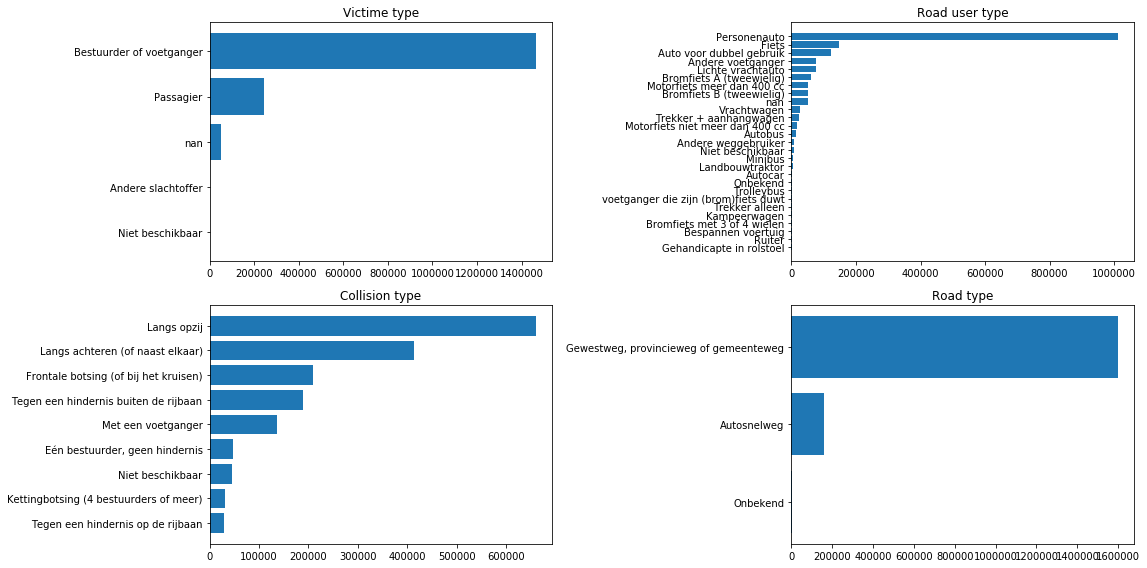

In [44]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

to_plot = accidents_cleaned['Victime type (driver, passenger, other victime)'].value_counts(dropna=False, ascending=True)
axes[0][0].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[0][0].set_title('Victime type')

to_plot = accidents_cleaned['Road user type'].value_counts(dropna=False, ascending=True)
axes[0][1].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[0][1].set_title('Road user type')

to_plot = accidents_cleaned['Collision type'].value_counts(dropna=False, ascending=True)
axes[1][0].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[1][0].set_title('Collision type')

to_plot = accidents_cleaned['Road type'].value_counts(dropna=False, ascending=True)
axes[1][1].barh(np.arange(len(to_plot)),to_plot.values, tick_label=to_plot.index)
axes[1][1].set_title('Road type')

figure.tight_layout()

In [45]:
accidents_cleaned = accidents_cleaned.loc[accidents_cleaned['Collision type']=='Met een voetganger',:]
accidents_cleaned = accidents_cleaned.loc[accidents_cleaned['Road type'] != 'Autosnelweg',:]

## Give some kind of severity to accidents

I thought to give a severity to accidents, and accident where somebody died is off course more severity than an accident with a slightly injured. But as this is subjective and open to interpretation, I did not use this at the end.

In [46]:
severity_weights = {'Number of slightly injured':1,
                    'Number of severely injured': 10,
                   'Number of mortally injured': 20,
                   'Number of dead': 20,
                   'Number of dead 30 days': 20}

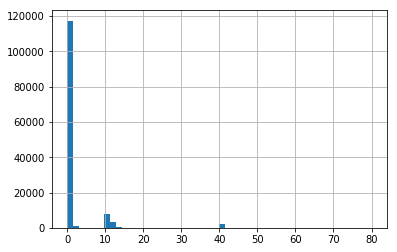

In [47]:
accidents_cleaned['total_severity'] = 0
for key, value in severity_weights.items():
    accidents_cleaned['total_severity'] += accidents_cleaned[key] * value
    
accidents_cleaned['total_severity'].hist(bins=50)

## Merge accidents with number of inhabitants

In [48]:
accidents_cleaned = accidents_cleaned.rename(columns={'REFNIS code of the municipality': 'niscode'})
accidents_cleaned = pd.merge(accidents_cleaned, aantal_inwoners[['inwoners', 'niscode', 'year']], how='left', 
                             left_on=['niscode', 'year'],  right_on=['niscode', 'year'])


## Group by commune and year

By aggregating the with the function len, I just count the number of accidents per commune per year

In [52]:
accidents_per_commune = accidents_cleaned.groupby(['Municipality name in Dutch', 'year'])['total_severity'].agg(len)
accidents_per_commune = accidents_per_commune.reset_index()

,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant
7064,Schaarbeek,2016,117.0,21015,134943.0,0.000867


In [57]:
niscodes = accidents_cleaned[['Municipality name in Dutch', 'niscode']].drop_duplicates()
accidents_per_commune = pd.merge(accidents_per_commune, niscodes, how='left')
accidents_per_commune.columns = ['gemeente', 'year', 'aantal_accidenten', 'niscode']
accidents_per_commune = pd.merge(accidents_per_commune, aantal_inwoners[['niscode', 'year', 'inwoners']], how='left', 
                                 left_on=['niscode', 'year'], right_on=['niscode', 'year'])
accidents_per_commune['accidents_per_inhabitant'] = accidents_per_commune['aantal_accidenten'] / accidents_per_commune['inwoners']

In [61]:
# Some verifications
check=len(accidents_cleaned.loc[(accidents_cleaned['Municipality name in Dutch']=='Schaarbeek')&
                         (accidents_cleaned['year']==2016),:])
print('Number of accidents in schaarbeek in 2016 schould be: {}'.format(check))

accidents_per_commune.loc[(accidents_per_commune['gemeente']=='Schaarbeek')&
                          (accidents_per_commune['year']==2016),:]

Number of accidents in schaarbeek in 2016 schould be: 117


,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant
7064,Schaarbeek,2016,117.0,21015,134943.0,0.000867


In [71]:
accidents_per_commune['inwoners_log'] = np.log10(accidents_per_commune['inwoners']+1)
accidents_per_commune['aantal_accidenten_log'] = np.log10(accidents_per_commune['aantal_accidenten']+1)
accidents_per_commune.sample(5)

,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant,inwoners_log,aantal_accidenten_log
8609,Wielsbeke,2005,2.0,37017,8821.0,0.000227,3.945567,0.477121
8997,Zutendaal,1995,6.0,71067,6669.0,0.000900,3.824126,0.845098
4735,Lendelede,2006,4.0,34025,5482.0,0.000730,3.739018,0.698970
5118,Londerzeel,2016,2.0,23045,18310.0,0.000109,4.262712,0.477121
5464,Meix-devant-Virton,2013,2.0,85024,2806.0,0.000713,3.448242,0.477121


## Is Schaarbeek worse per capita than other communes in 2016?

With the number of accidents per commune in 2016, we are now ready to answer the first question.

In [72]:
accidents_per_commune_2016 = accidents_per_commune.loc[accidents_per_commune['year']==2016,:].copy()
accidents_per_commune_2016['accidents_per_inhabitant'] = accidents_per_commune_2016['accidents_per_inhabitant']*1000

In [73]:
accidents_per_commune_2016['Brusselse_gemeente'] = accidents_per_commune_2016['gemeente'].isin(brusselse_gemeenten)

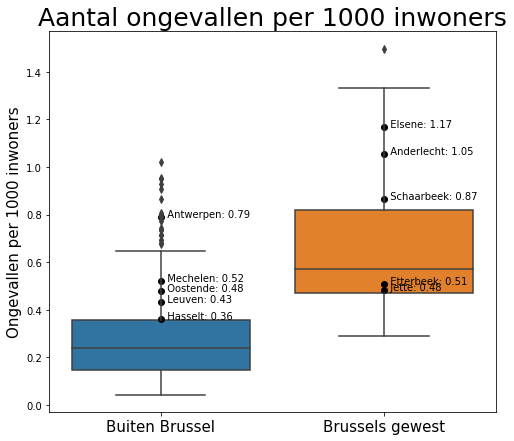

In [74]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
sb.boxplot(x="Brusselse_gemeente", y="accidents_per_inhabitant", data=accidents_per_commune_2016, ax=ax)
ax.set_xlabel('')
ax.set_xticklabels(['Buiten Brussel', 'Brussels gewest'], size=15)
ax.set_ylabel('Ongevallen per 1000 inwoners', size=15)
ax.set_title('Aantal ongevallen per 1000 inwoners', size=25)

gemeentes = ['Jette', 'Anderlecht', 'Elsene', 'Etterbeek', 'Schaarbeek', 'Mechelen', 'Antwerpen', 'Hasselt', 'Leuven', 'Oostende']

to_plot = accidents_per_commune_2016.loc[accidents_per_commune_2016['gemeente'].isin(gemeentes),:]
to_plot.index = np.arange(len(to_plot))

for i, row in to_plot.iterrows():
    
    ax.scatter(y=row['accidents_per_inhabitant'], x=row['Brusselse_gemeente'], color='black', )
    ax.text(y=row['accidents_per_inhabitant'], x=row['Brusselse_gemeente'], color='black', size=10,
            s='  {}: {:.2f}'.format(row['gemeente'], row['accidents_per_inhabitant']))


#ax = sb.swarmplot(x="Brusselse_gemeente", y="accidents_per_inhabitant", data=accidents_per_commune_2016, color=".25")

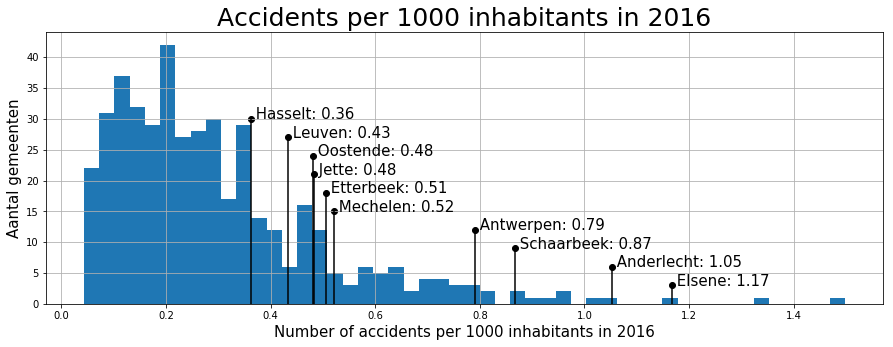

In [75]:
figure, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))
accidents_per_commune_2016['accidents_per_inhabitant'].hist(ax=ax,bins=50 )
ax.set_title('Accidents per 1000 inhabitants in 2016', size=25)
ax.set_xlabel('Number of accidents per 1000 inhabitants in 2016', size=15)
ax.set_ylabel('Aantal gemeenten', size=15)
gemeentes = ['Jette', 'Anderlecht', 'Elsene', 'Etterbeek', 'Schaarbeek', 'Mechelen', 'Antwerpen', 'Hasselt', 'Leuven', 'Oostende']
to_plot = accidents_per_commune_2016.loc[accidents_per_commune_2016['gemeente'].isin(gemeentes),['gemeente','accidents_per_inhabitant']]
to_plot = to_plot.sort_values('accidents_per_inhabitant')
to_plot.index = np.arange(len(to_plot))
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

for i, row in to_plot.iterrows():
    
    ax.scatter(row['accidents_per_inhabitant'], y=30 - 3*i, color='black', )
    ax.vlines(x=row['accidents_per_inhabitant'], ymin=0, ymax=30 - 3*i, color='black')
    ax.text(x=row['accidents_per_inhabitant'],  y=30 - 3*i, color='black', s=' {}: {:.2f}'.format(
        row['gemeente'], row['accidents_per_inhabitant']), size=15)

In [76]:
print('50% of the communes has less than {:.2f} accidents with pedestrians per year per inhabitant'.format(
    np.percentile(accidents_per_commune_2016['accidents_per_inhabitant'],50)))
print('{} communes had only one accident with a pedestrian in 2016'.format(
    sum(accidents_per_commune_2016['aantal_accidenten']==1)))

50% of the communes has less than 0.25 accidents with pedestrians per year per inhabitant
94 communes had only one accident with a pedestrian in 2016


In [77]:
# Best communes
accidents_per_commune_2016.sort_values('accidents_per_inhabitant', ascending=True).head(10)

,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant,inwoners_log,aantal_accidenten_log,Brusselse_gemeente
8844,Zemst,2016,1.0,23096,22955.0,0.043563,4.360896,0.30103,False
571,Balen,2016,1.0,13003,22223.0,0.044998,4.346822,0.30103,False
3761,Hoogstraten,2016,1.0,13014,21370.0,0.046795,4.329825,0.30103,False
3484,Herent,2016,1.0,24038,21300.0,0.046948,4.328400,0.30103,False
7310,Sint-Katelijne-Waver,2016,1.0,12035,20510.0,0.048757,4.311987,0.30103,False
4699,Lebbeke,2016,1.0,42011,18899.0,0.052913,4.276462,0.30103,False
6686,Ranst,2016,1.0,11035,18792.0,0.053214,4.273996,0.30103,False
4181,Kasterlee,2016,1.0,13017,17958.0,0.055685,4.254282,0.30103,False
7631,Stekene,2016,1.0,46024,17828.0,0.056092,4.251127,0.30103,False
3625,Herzele,2016,1.0,41027,17547.0,0.056990,4.244228,0.30103,False


In [78]:
# Worst communes
accidents_per_commune_2016.sort_values('accidents_per_inhabitant', ascending=True).tail(10)

,gemeente,year,aantal_accidenten,niscode,inwoners,accidents_per_inhabitant,inwoners_log,aantal_accidenten_log,Brusselse_gemeente
7064,Schaarbeek,2016,117.0,21015,134943.0,0.867033,5.130154,2.071882,True
5182,Luik,2016,179.0,62063,197404.0,0.906770,5.295358,2.255273,False
4273,Knokke-Heist,2016,31.0,31043,33422.0,0.927533,4.524045,1.505150,False
4425,Kortessem,2016,8.0,73040,8418.0,0.950344,3.925261,0.954243,False
2132,Drogenbos,2016,5.0,23098,5233.0,0.955475,3.718834,0.778151,False
1078,Boom,2016,18.0,11005,17651.0,1.019772,4.246794,1.278754,False
244,Anderlecht,2016,126.0,21001,119709.0,1.052552,5.078130,2.103804,True
2305,Elsene,2016,100.0,21009,85722.0,1.166562,4.933097,2.004321,True
7233,Sint-Gillis,2016,69.0,21013,51810.0,1.331789,4.714422,1.845098,True
1368,Brussel,2016,267.0,21004,178280.0,1.497644,5.251105,2.428135,True


Commune with maximum accidents:


gemeente                    Antwerpen
year                             2016
aantal_accidenten                 413
niscode                         11002
inwoners                       522644
accidents_per_inhabitant     0.790213
inwoners_log                  5.71821
aantal_accidenten_log           2.617
Brusselse_gemeente              False
Name: 336, dtype: object

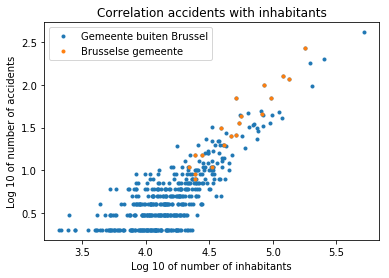

In [89]:
figure, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(accidents_per_commune_2016['inwoners_log'],
         accidents_per_commune_2016['aantal_accidenten_log'], '.', label='Gemeente buiten Brussel')
axes.plot(accidents_per_commune_2016.loc[accidents_per_commune_2016['Brusselse_gemeente'],'inwoners_log'],
         accidents_per_commune_2016.loc[accidents_per_commune_2016['Brusselse_gemeente'], 'aantal_accidenten_log'], '.', label='Brusselse gemeente')
axes.legend()
axes.set_xlabel('Log 10 of number of inhabitants')
axes.set_ylabel('Log 10 of number of accidents')
axes.set_title('Correlation accidents with inhabitants')
print('Commune with maximum accidents:')
accidents_per_commune_2016.loc[accidents_per_commune_2016['aantal_accidenten_log'].idxmax(),:]

## What about the trend?

Does the number of accidents with pedestrians in Schaarbeek decrease or increase? What about other communes? 
<br><br>
A first plot makes it clear that the data is useless for this analysis. There are at least two structural breaks, one in 2009 and one in 2013. These structural breaks are not documented, and we do not know if:

- There was a true decline in accidents due to some measurements (this is hard to believe, given the number of accidents dropped in schaarbeek from around 600 to 200)
- There was a change in methodology of reporting.

The latter seems the most likely. 
<br><br>
It could also be due to the filters I applied, with only pedestrians or no accidents on the highway. But I tried with no filters as well, just the number of accidents, and the same structural breaks appeared.

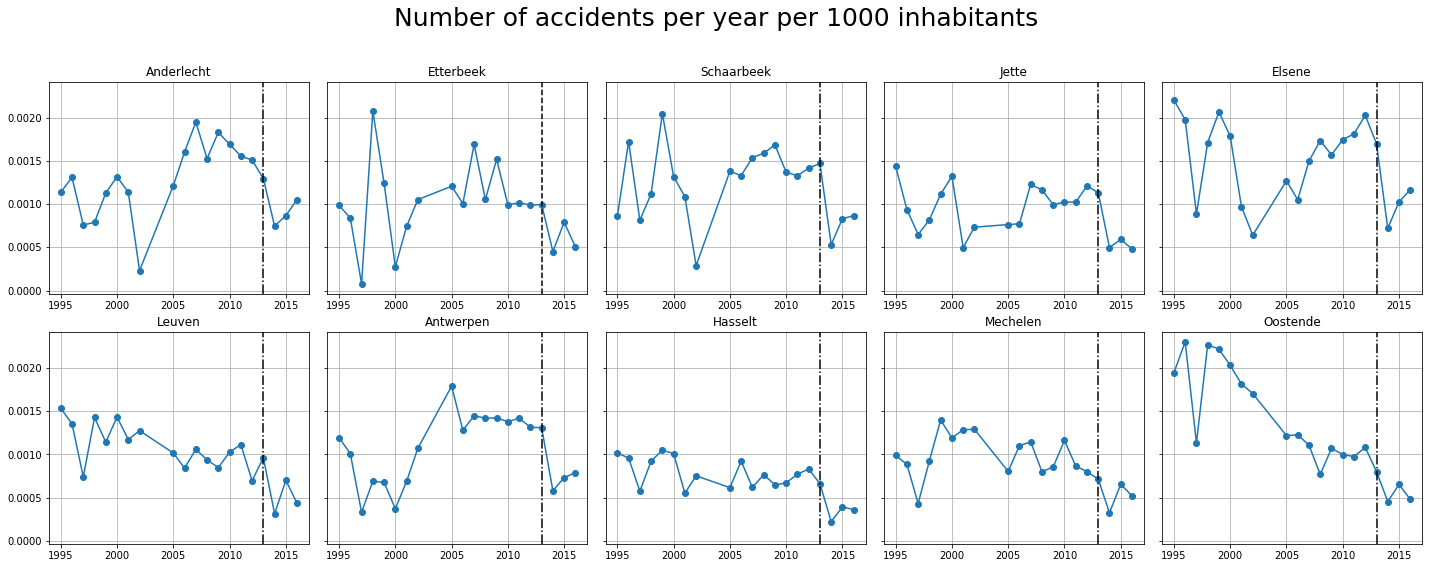

In [90]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharey=True)

accidents_hasselt = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Anderlecht', :].sort_values('year')
axes[0][0].plot(accidents_hasselt['year'], accidents_hasselt['accidents_per_inhabitant'], '-o')
axes[0][0].set_title('Anderlecht')
axes[0][0].axvline(2013, linestyle='-.', color='black')
axes[0][0].grid()

accidents_leuven = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Etterbeek', :].sort_values('year')
axes[0][1].plot(accidents_leuven['year'], accidents_leuven['accidents_per_inhabitant'], '-o')
axes[0][1].set_title('Etterbeek')
axes[0][1].axvline(2013, linestyle='--', color='black')
axes[0][1].grid()


accidents_schaarbeek = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Schaarbeek', :].sort_values('year')
axes[0][2].plot(accidents_schaarbeek['year'], accidents_schaarbeek['accidents_per_inhabitant'], '-o')
axes[0][2].set_title('Schaarbeek')
axes[0][2].axvline(2013, linestyle='-.', color='black')
axes[0][2].grid()


accidents_jette = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Jette', :].sort_values('year')
axes[0][3].plot(accidents_jette['year'], accidents_jette['accidents_per_inhabitant'], '-o')
axes[0][3].set_title('Jette')
axes[0][3].axvline(2013, linestyle='-.', color='black')
axes[0][3].grid()

accidents_tervuren = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Elsene', :].sort_values('year')
axes[0][4].plot(accidents_tervuren['year'], accidents_tervuren['accidents_per_inhabitant'], '-o')
axes[0][4].set_title('Elsene')
axes[0][4].axvline(2013, linestyle='-.', color='black')
axes[0][4].grid()

accidents_hasselt = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Leuven', :].sort_values('year')
axes[1][0].plot(accidents_hasselt['year'], accidents_hasselt['accidents_per_inhabitant'], '-o')
axes[1][0].set_title('Leuven')
axes[1][0].axvline(2013, linestyle='-.', color='black')
axes[1][0].grid()

accidents_leuven = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Antwerpen', :].sort_values('year')
axes[1][1].plot(accidents_leuven['year'], accidents_leuven['accidents_per_inhabitant'], '-o')
axes[1][1].set_title('Antwerpen')
axes[1][1].axvline(2013, linestyle='-.', color='black')
axes[1][1].grid()


accidents_schaarbeek = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Hasselt', :].sort_values('year')
axes[1][2].plot(accidents_schaarbeek['year'], accidents_schaarbeek['accidents_per_inhabitant'], '-o')
axes[1][2].set_title('Hasselt')
axes[1][2].axvline(2013, linestyle='-.', color='black')
axes[1][2].grid()


accidents_jette = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Mechelen', :].sort_values('year')
axes[1][3].plot(accidents_jette['year'], accidents_jette['accidents_per_inhabitant'], '-o')
axes[1][3].set_title('Mechelen')
axes[1][3].axvline(2013, linestyle='-.', color='black')
axes[1][3].grid()

accidents_tervuren = accidents_per_commune.loc[accidents_per_commune['gemeente']=='Oostende', :].sort_values('year')
axes[1][4].plot(accidents_tervuren['year'], accidents_tervuren['accidents_per_inhabitant'], '-o')
axes[1][4].set_title('Oostende')
axes[1][4].axvline(2013, linestyle='-.', color='black')

axes[1][4].grid()

figure.suptitle('Number of accidents per year per 1000 inhabitants', size=25)
figure.tight_layout()
figure.subplots_adjust(top=0.85)